In [52]:
# Use the testing mode for evaluation (the whole ready-to-go model), since we 
# are not contributing to the model itself
# If user would like to use this acceleration, select the menu option 
# "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and
# click "SAVE"
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from torchvision import transforms

from tqdm.autonotebook import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch, os
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np

from random import sample

# selected ResNet34 as the model
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
classes = ["Apple Golden 1", "Apple Golden 2", "Apple Golden 3", "Apple Granny Smith", "Apple Pink Lady"]

def gettrainfiles(): 
    _files, classidx, _filefullpath = [], [], []
    for cls in range(len(classes)):
        classidx += [cls] * len(os.listdir(traindir + '\\' + classes[cls]))
        _files += os.listdir(traindir + '\\' + classes[cls])
        for f in os.listdir(traindir + '\\' + classes[cls]):
            _filefullpath.append(traindir + '\\' + classes[cls] + '\\' + f)
    return [_files, classidx, _filefullpath]
def gettestfiles(): 
    _files, classidx, _filefullpath = [], [], []
    for cls in range(len(classes)):
        classidx += [cls] * len(os.listdir(testdir + '\\' + classes[cls]))
        _files += os.listdir(testdir + '\\' + classes[cls])
        for f in os.listdir(testdir + '\\' + classes[cls]):
            _filefullpath.append(testdir + '\\' + classes[cls] + '\\' + f)
    return [_files, classidx, _filefullpath]

root_path = 'C:\\Users\\wangz\\Documents\\GitHub\\ECE561MachineVision\\FinalProject\\Q2\\fruits\\fruits-360_dataset\\fruits-360'
traindir = root_path + '\\Training'
testdir = root_path + '\\Test'

trainfiles = gettrainfiles()[0]
trainclasses = gettrainfiles()[1]
trainfilefullpaths = gettrainfiles()[2]
testfiles = gettestfiles()[0]
testclasses = gettestfiles()[1]
testfilefullpaths = gettestfiles()[2]

print("Training Data Size: " + str(len(trainfiles)))
print("Testing Data Size: " + str(len(testfiles)))

Using cache found in C:\Users\wangz/.cache\torch\hub\pytorch_vision_master


Training Data Size: 2413
Testing Data Size: 805


In [43]:
# Q2 (a) recognition experiment:
# here I have not yet started fine-tuning the network 
with open(root_path + '\\' + 'imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

model.eval()

test_true, test_pred = [], []
sample_50_image_idx = [x for x in sample(range(len(gettestfiles()[0])),50)]
input_images = sample_50_image_paths = [Image.open(gettestfiles()[2][x]) for x in sample_50_image_idx]
test_true = [classes[testclasses[x]] for x in sample_50_image_idx]
for i in range(len(input_images)):
    preprocess = transforms.Compose([
                  transforms.CenterCrop(224),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                       std=[0.229, 0.224, 0.225]),])
    input_tensor = preprocess(input_images[i])
    input_batch = input_tensor.unsqueeze(0)
    # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    _, index = torch.max(output, 1)
    # The output has unnormalized scores. To get probabilities, run a 
    # softmax on it (to normalize the scores to probability).
    percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
    pred_label_i = labels[index[0]]
    test_pred.append(pred_label_i)

print("Recognition Experiment Using ImageNet pre-trained model on the Fruit360 Data:")
print('\t', "True Fruit Class", '\t', "Predicted ImageNet Class")
print('\t', "################", '\t', "########################\n")

for i in range(len(sample_50_image_idx)):
    print('\t', test_true[i], '\t\t', test_pred[i])

Recognition Experiment Using ImageNet pre-trained model on the Fruit360 Data:
	 True Fruit Class 	 Predicted ImageNet Class
	 ################ 	 ########################

	 Apple Golden 3 		 Granny Smith
	 Apple Golden 2 		 Granny Smith
	 Apple Pink Lady 		 Granny Smith
	 Apple Pink Lady 		 Granny Smith
	 Apple Golden 2 		 Granny Smith
	 Apple Golden 3 		 Granny Smith
	 Apple Granny Smith 		 Granny Smith
	 Apple Pink Lady 		 orange
	 Apple Granny Smith 		 Granny Smith
	 Apple Pink Lady 		 Granny Smith
	 Apple Golden 2 		 Granny Smith
	 Apple Golden 2 		 Granny Smith
	 Apple Golden 2 		 Granny Smith
	 Apple Golden 1 		 lemon
	 Apple Granny Smith 		 Granny Smith
	 Apple Golden 2 		 Granny Smith
	 Apple Golden 2 		 Granny Smith
	 Apple Pink Lady 		 pomegranate
	 Apple Golden 3 		 Granny Smith
	 Apple Golden 1 		 lemon
	 Apple Pink Lady 		 orange
	 Apple Golden 1 		 custard apple
	 Apple Granny Smith 		 Granny Smith
	 Apple Pink Lady 		 Granny Smith
	 Apple Golden 2 		 Granny Smith
	 Apple

In [64]:
# Functional Utilities
class FiveClassFruit(Dataset):
    def __init__(self, filelist, classlist, fullfilepath, transform=None):
        self.filelist = filelist
        self.classlist = classlist
        self.fullfilepath = fullfilepath
        self.transform = transform
    
    def __len__(self):
        assert len(self.filelist) == len(self.classlist) == len(self.fullfilepath)
        return len(self.filelist)
    
    def __getitem__(self, idx):
        img_name = self.filelist[idx]            
        fullname = self.fullfilepath[idx]
        cls = self.classlist[idx]
        image = Image.open(fullname)
        if self.transform:
            image = self.transform(image)
        return [image, cls]

def get_data_loaders(train_batch_size=8, val_batch_size=2):    
    data_transform = Compose([Resize((224,224)),
                              CenterCrop(224),
                              ToTensor(), 
                              Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])])

    train_loader = DataLoader(FiveClassFruit(trainfiles, 
                                             trainclasses,
                                             trainfilefullpaths, 
                                             transform=data_transform),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(FiveClassFruit(testfiles, 
                                           testclasses,
                                           testfilefullpaths, 
                                           transform=data_transform),
                            batch_size=val_batch_size, shuffle=False)
    # use the train dataset for both train and validation (no labels on testset)
    return train_loader, val_loader

def calculate_metric(metric_fn, true_y, pred_y):
    # multi class problems need to have averaging method
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

def train_and_val(model):
    losses.append([]) # training losses
    losses.append([]) # validation losses
    
    batches = len(train_loader)
    val_batches = len(val_loader)

    # loop for every epoch (training + evaluation)
    for epoch in range(epochs):
        total_loss = 0

        # progress bar
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

        # ----------------- TRAINING  -------------------- 
        # set model to training
        model.train()
        for i, data in progress:
            X, y = data[0].to(device), data[1].to(device)

            # training step for single batch
            model.zero_grad()
            outputs = model(X)
            loss = loss_function(outputs, y)
            loss.backward()
            optimizer.step()
            losses[0].append(total_loss/(i+1)) # for plotting learning curve

            # getting training quality data
            current_loss = loss.item()
            total_loss += current_loss

            # updating progress bar
            progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

        # releasing unceseccary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ----------------- VALIDATION  ----------------- 
        val_losses = 0
        precision, recall, f1, accuracy = [], [], [], []
        true_cls, pred_cls = [], []
        # set model to evaluating (testing)
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data[0].to(device), data[1].to(device)
                # Get's the prediction (outputs) from the network
                outputs = model(X)
                losses[1].append(val_losses/(i+1)) # for plotting learning curve

                val_losses += loss_function(outputs, y)

                predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
                true_cls.extend(y.cpu())
                pred_cls.extend(predicted_classes.cpu())

                # calculate P/R/F1/A metrics for batch
                for acc, metric in zip((precision, recall, f1, accuracy), 
                                       (precision_score, recall_score, f1_score, accuracy_score)):
                    acc.append(calculate_metric(metric, 
                                                y.cpu(), predicted_classes.cpu()))
            print(confusion_matrix(true_cls, pred_cls, labels=[0,1,2,3,4]))
            print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
            print_scores(precision, recall, f1, accuracy, val_batches)
    plt.plot(np.array(losses[0]) , 'r', label="train")
    plt.plot(np.array(losses[1]) , 'b', label="validation")
    plt.legend(loc="upper right")
    print(f"Training time: {time.time()-start_ts}s")

Using cache found in C:\Users\wangz/.cache\torch\hub\pytorch_vision_master


Pretrained ResNet18 with fine-tuning the fully-connected layer only:
Batch Norms are all activated as pretraied parameters:



[[164   0   0   0   0]
 [  0 164   0   0   0]
 [  0   0 161   0   0]
 [  0   3  20 141   0]
 [  0   0   0   0 152]]
Epoch 1/3, training loss: 0.6792712768441752, validation loss: 0.30870378017425537
	     precision: 0.9542
	        recall: 0.9420
	            F1: 0.9465
	      accuracy: 0.9718



[[164   0   0   0   0]
 [  0 164   0   0   0]
 [  0   0 161   0   0]
 [  0   0  12 152   0]
 [  0   0   0   0 152]]
Epoch 2/3, training loss: 0.18680929686678083, validation loss: 0.14888235926628113
	     precision: 0.9706
	        recall: 0.9632
	            F1: 0.9663
	      accuracy: 0.9853



[[164   0   0   0   0]
 [  0 164   0   0   0]
 [  0   0 161   0   0]
 [  0   0  22 142   0]
 [  0   0   0   0 152]]
Epoch 3/3, training loss: 0.10431137347691938, validation loss: 0.12675422430038452
	     precision: 0.9542
	        recall: 0.9409
	            F1: 0.9458
	      accuracy: 0.9730
Training time: 47.93038487434387s


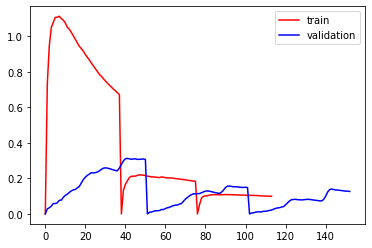

In [65]:
# Use ResNet18 for fine-tuning fully connected layer to achieve the best results
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
# Fine-tuning: First modify the model configurations
# set all weights to be fixed: not back-propogating gradients
# set the number of classes as 5 (required by the project)
# replace the last layer with our custmozied linear layer with 5 out features (5 classes)
class_num = len(classes)
channel_in = model.fc.in_features

model.fc = nn.Linear(in_features=channel_in, out_features=class_num)
for params in model.parameters():
    params.requires_grad = False

# set the fully connected layer to be trainable: require back-propogation of gradients
for params in model.fc.parameters():
    params.requires_grad = True

epochs = 3
train_loader, val_loader = get_data_loaders(64,16)# put your data loader here, play with batch size to satisfy cuda
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, try Adam this time to have a taste
# optimize the full connection layer only, magic numbers from online resource
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999))

os.environ['CUDA_VISIBLE_DEVICES']='0'

start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = True

torch.cuda.empty_cache()
model.cuda()

losses = []

print("Pretrained ResNet18 with fine-tuning the fully-connected layer only:")
print("Batch Norms are all activated as pretraied parameters:")

train_and_val(model)

Using cache found in C:\Users\wangz/.cache\torch\hub\pytorch_vision_master


Pretrained ResNet18 with fine-tuning the fully-connected layer only:
Last layer Batch Norm Children are all deactivated (replaced by Identitiy layer):



C:\Users\wangz\.conda\envs\py36cv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\wangz\.conda\envs\py36cv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[164   0   0   0   0]
 [160   4   0   0   0]
 [161   0   0   0   0]
 [ 96   7   0  61   0]
 [141   0   0   0  11]]
Epoch 1/10, training loss: 1.5649245381355286, validation loss: 1.5272979736328125
	     precision: 0.3374
	        recall: 0.2506
	            F1: 0.2608
	      accuracy: 0.2941



[[164   0   0   0   0]
 [148  16   0   0   0]
 [131   0  16  14   0]
 [  1   0   0 163   0]
 [ 59   0   0   0  93]]
Epoch 2/10, training loss: 1.4789094705330699, validation loss: 1.4479002952575684
	     precision: 0.5923
	        recall: 0.4800
	            F1: 0.4936
	      accuracy: 0.5674



[[164   0   0   0   0]
 [ 43 121   0   0   0]
 [ 35  29  86  11   0]
 [  0   0   0 164   0]
 [ 21   0   0   0 131]]
Epoch 3/10, training loss: 1.3996672002892745, validation loss: 1.3763163089752197
	     precision: 0.7700
	        recall: 0.7103
	            F1: 0.7275
	      accuracy: 0.8297



[[164   0   0   0   0]
 [ 35 129   0   0   0]
 [ 27   7 100  27   0]
 [  0   0   0 164   0]
 [ 15   0   0   0 137]]
Epoch 4/10, training loss: 1.3260411620140076, validation loss: 1.3101083040237427
	     precision: 0.7817
	        recall: 0.7346
	            F1: 0.7501
	      accuracy: 0.8640



[[164   0   0   0   0]
 [ 60 104   0   0   0]
 [ 17   0 142   2   0]
 [  0   0   0 164   0]
 [  7   0   0   0 145]]
Epoch 5/10, training loss: 1.2586437275535183, validation loss: 1.245453119277954
	     precision: 0.8340
	        recall: 0.7862
	            F1: 0.8003
	      accuracy: 0.8946



[[164   0   0   0   0]
 [ 11 153   0   0   0]
 [ 13   7 134   7   0]
 [  0   0   0 164   0]
 [  6   0   0   0 146]]
Epoch 6/10, training loss: 1.1965293821535612, validation loss: 1.1874240636825562
	     precision: 0.8480
	        recall: 0.8268
	            F1: 0.8351
	      accuracy: 0.9461



[[164   0   0   0   0]
 [  2 162   0   0   0]
 [  8   3 147   3   0]
 [  0   0   0 164   0]
 [  0   0   0   0 152]]
Epoch 7/10, training loss: 1.135680891965565, validation loss: 1.131540298461914
	     precision: 0.9314
	        recall: 0.9222
	            F1: 0.9260
	      accuracy: 0.9804



[[164   0   0   0   0]
 [  0 164   0   0   0]
 [  5   6 147   3   0]
 [  0   0   0 164   0]
 [  0   0   0   0 152]]
Epoch 8/10, training loss: 1.0797529000984996, validation loss: 1.0828502178192139
	     precision: 0.9346
	        recall: 0.9281
	            F1: 0.9309
	      accuracy: 0.9828



[[164   0   0   0   0]
 [  0 164   0   0   0]
 [  5   6 147   3   0]
 [  0   0   0 164   0]
 [  0   0   0   0 152]]
Epoch 9/10, training loss: 1.028961796509592, validation loss: 1.0355521440505981
	     precision: 0.9346
	        recall: 0.9281
	            F1: 0.9309
	      accuracy: 0.9828



[[164   0   0   0   0]
 [  1 163   0   0   0]
 [  6   2 153   0   0]
 [  0   0   0 164   0]
 [  0   0   0   0 152]]
Epoch 10/10, training loss: 0.9842145662558707, validation loss: 0.9903035759925842
	     precision: 0.9641
	        recall: 0.9583
	            F1: 0.9608
	      accuracy: 0.9890
Training time: 159.89371299743652s


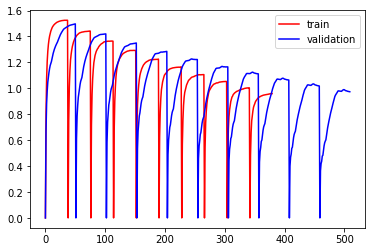

In [66]:
# Use ResNet18 for testing Batch Normalization
# ResNet pretrained models already uses BatchNorm at each layer
# At this experiment, deactivate some BatchNorm children layers to see the performance difference
# Still need to modify the fc layer because we are dealing with a five-class classification problem
model = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
# set the number of classes as 5 (required by the project)
# replace the last layer with our custmozied linear layer with 5 out features (5 classes)
class_num = len(classes)
channel_in = model.fc.in_features
model.fc = nn.Linear(in_features=channel_in, out_features=class_num)

# Deactivating the BatchNorms of the last layer
model.layer4[0].bn1 = nn.Identity()
model.layer4[0].bn2 = nn.Identity()
model.layer4[1].bn1 = nn.Identity()
model.layer4[1].bn2 = nn.Identity()


# Fine-tuning: First modify the model configurations
# set all weights to be fixed: not back-propogating gradients
for params in model.parameters():
    params.requires_grad = False

# set the fully connected layer to be trainable: require back-propogation of gradients
for params in model.fc.parameters():
    params.requires_grad = True



epochs = 10
train_loader, val_loader = get_data_loaders(64,16)# put your data loader here, play with batch size to satisfy cuda
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, try Adam this time to have a taste
# optimize the full connection layer only, magic numbers from online resource
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999))

os.environ['CUDA_VISIBLE_DEVICES']='0'

start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = True

torch.cuda.empty_cache()
model.cuda()

losses = []

print("Pretrained ResNet18 with fine-tuning the fully-connected layer only:")
print("Last layer Batch Norm Children are all deactivated (replaced by Identitiy layer):\n")

train_and_val(model)

Using cache found in C:\Users\wangz/.cache\torch\hub\pytorch_vision_master


Pretrained Alexnet with fine-tuning the last linear layer only:
Alexnet With Dropout Fully Activated:




[[164   0   0   0   0]
 [  0 158   6   0   0]
 [  0   0 161   0   0]
 [  0   0  17 147   0]
 [  0   0   0   0 152]]
Epoch 1/3, training loss: 60.47746202388876, validation loss: 0.25817087292671204
	     precision: 0.9510
	        recall: 0.9369
	            F1: 0.9423
	      accuracy: 0.9718



[[164   0   0   0   0]
 [  0 164   0   0   0]
 [  0  23 138   0   0]
 [  0   0   1 163   0]
 [  0   0   0   0 152]]
Epoch 2/3, training loss: 1.35231897862334, validation loss: 0.45025554299354553
	     precision: 0.9510
	        recall: 0.9363
	            F1: 0.9399
	      accuracy: 0.9706



[[164   0   0   0   0]
 [  0 164   0   0   0]
 [  0   9 152   0   0]
 [  0   0   0 164   0]
 [  0   0   0   0 152]]
Epoch 3/3, training loss: 0.6754586296646219, validation loss: 0.08567622303962708
	     precision: 0.9706
	        recall: 0.9651
	            F1: 0.9674
	      accuracy: 0.9890
Training time: 26.655691385269165s


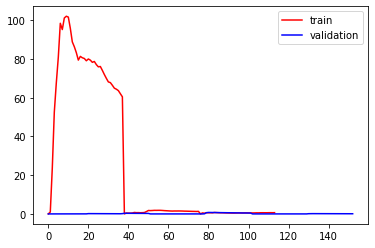

In [67]:
# Use Alexnet for testing Dropout Regularization
# Alexnet already uses 0.5 in three dropout layers
# Modify the classfier[6] of Alexnet to fine tune
model = torch.hub.load('pytorch/vision', 'alexnet', pretrained=True)
model.classifier[6] = nn.Linear(4096, len(classes))

# set all weights to be fixed: not back-propogating gradients
for params in model.parameters():
    params.requires_grad = False

# set the classifier[6] layer to be trainable: require back-propogation of gradients
for params in model.classifier[6].parameters():
    params.requires_grad = True

epochs = 3
train_loader, val_loader = get_data_loaders(64,16)# put your data loader here, play with batch size to satisfy cuda
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# construct the stochastic gradient descent opimizer 
# and filter-out those parameters requiring gradient inputs (previsou layers)
optimizer = torch.optim.SGD(params=filter(lambda p: p.requires_grad, model.parameters()), lr=0.1)

os.environ['CUDA_VISIBLE_DEVICES']='0'

start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = True

torch.cuda.empty_cache()
model.cuda()

losses = []

print("Pretrained Alexnet with fine-tuning the last linear layer only:")
print("Alexnet With Dropout Fully Activated:\n")
train_and_val(model)

Using cache found in C:\Users\wangz/.cache\torch\hub\pytorch_vision_master


Pretrained Alexnet with fine-tuning the last linear layer only:
Alexnet With Dropout Fully Deactivated (replaced by Identity layers):




[[164   0   0   0   0]
 [  0 164   0   0   0]
 [  0  13 144   2   2]
 [  0   0   0 164   0]
 [  0   0   0   0 152]]
Epoch 1/3, training loss: 52.883347611678275, validation loss: 0.23288732767105103
	     precision: 0.9542
	        recall: 0.9469
	            F1: 0.9490
	      accuracy: 0.9792



[[164   0   0   0   0]
 [  0 163   1   0   0]
 [  0   6 155   0   0]
 [  0   0   0 164   0]
 [  0   0   0   0 152]]
Epoch 2/3, training loss: 0.013571308631646005, validation loss: 0.04631207510828972
	     precision: 0.9804
	        recall: 0.9761
	            F1: 0.9778
	      accuracy: 0.9914



[[164   0   0   0   0]
 [  0 160   4   0   0]
 [  0   2 159   0   0]
 [  0   0   0 164   0]
 [  0   0   0   0 152]]
Epoch 3/3, training loss: 0.0005619494538558157, validation loss: 0.030490204691886902
	     precision: 0.9706
	        recall: 0.9669
	            F1: 0.9686
	      accuracy: 0.9926
Training time: 26.808284282684326s


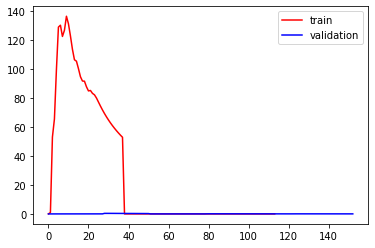

In [68]:
# Use Alexnet for testing Dropout Regularization
# Deactivating Dropout Layers by substituion of Identify layers
# Classifier[6] still needs to be modified because the number of classes has changed to 5
model = torch.hub.load('pytorch/vision', 'alexnet', pretrained=True)
model.classifier[6] = nn.Linear(4096, len(classes))

# deactivate the Dropout to see if there is difference or not
model.classifier[0] = nn.Identity()
model.classifier[3] = nn.Identity()

# set all weights to be fixed: not back-propogating gradients
for params in model.parameters():
    params.requires_grad = False

# set the classifier[6] layer to be trainable: require back-propogation of gradients
for params in model.classifier[6].parameters():
    params.requires_grad = True

epochs = 3
train_loader, val_loader = get_data_loaders(64,16)# put your data loader here, play with batch size to satisfy cuda
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# construct the stochastic gradient descent opimizer 
# and filter-out those parameters requiring gradient inputs (previsou layers)
optimizer = torch.optim.SGD(params=filter(lambda p: p.requires_grad, model.parameters()), lr=0.1)

os.environ['CUDA_VISIBLE_DEVICES']='0'

start_ts = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = True

torch.cuda.empty_cache()
model.cuda()

losses = []

print("Pretrained Alexnet with fine-tuning the last linear layer only:")
print("Alexnet With Dropout Fully Deactivated (replaced by Identity layers):\n")
train_and_val(model)